# 第10回講義 宿題

## 課題. RNN Encoder-Decoderで英日翻訳のモデルを実装せよ

### 注意

- homework関数を完成させて提出してください
    - 訓練データのtrain_X, train_yのみが与えられます
    - train_Xとtrain_yをtrain_X, valid_xとtrain_y, valid_yに分けるなどしてモデルを学習させてください
    - **cost関数を戻り値**としてください
- **test_X, test_yに対する交差エントロピー(負の対数尤度)の平均で評価**します
- 全体の実行時間がiLect上で60分を超えないようにしてください
- homework関数の外には何も書かないでください (必要なものは全てhomework関数に入れてください)
- 解答提出時には Answer Cell の内容のみを提出してください

次のセルのhomework関数を完成させて提出してください

# Answer Cell

In [17]:
def homework(train_X, train_y):
    global e_vocab_size, j_vocab_size, sess, x, d # 下記Checker Cell内 で定義した各変数を利用可能.
    class Embedding:
        def __init__(self, vocab_size, emb_dim, scale=0.08):
            self.V = tf.Variable(rng.randn(vocab_size, emb_dim).astype('float32') * scale, name='V')
        def f_prop(self, x):
            return tf.nn.embedding_lookup(self.V, x)
        def f_prop_test(self, x_t):
            return tf.nn.embedding_lookup(self.V, x_t)
        
    class LSTM:
        def __init__(self, in_dim, hid_dim, m, h_0=None, c_0=None):
            self.in_dim = in_dim
            self.hid_dim = hid_dim
            # input gate
            self.W_xi = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xi')
            self.W_hi = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_hi')
            self.b_i  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_i')
            # forget gate
            self.W_xf = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xf')
            self.W_hf = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xf')
            self.b_f  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_f')
            # output gate
            self.W_xo = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xo')
            self.W_ho = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_ho')
            self.b_o  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_o')
            # cell state
            self.W_xc = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xc')
            self.W_hc = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_hc')
            self.b_c  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_c')
            # initial state
            self.h_0 = h_0
            self.c_0 = c_0
            # mask
            self.m = m
        def f_prop(self, x):
            def fn(tm1, x_and_m):
                h_tm1 = tm1[0]
                c_tm1 = tm1[1]
                x_t = x_and_m[0]
                m_t = x_and_m[1]
                # input gate
                i_t = tf.nn.relu(tf.matmul(x_t, self.W_xi) + tf.matmul(h_tm1, self.W_hi) + self.b_i)
                # forget gate
                f_t = tf.nn.relu(tf.matmul(x_t, self.W_xf) + tf.matmul(h_tm1, self.W_hf) + self.b_f)
                # output gate
                o_t = tf.nn.relu(tf.matmul(x_t, self.W_xo) + tf.matmul(h_tm1, self.W_ho) + self.b_o)
                # cell state
                c_t = f_t * c_tm1 + i_t * tf.nn.tanh(tf.matmul(x_t, self.W_xc) + tf.matmul(h_tm1, self.W_hc) + self.b_c)
                c_t = m_t[:, np.newaxis] * c_t + (1. - m_t[:, np.newaxis]) * c_tm1 # Mask
                # hidden state
                h_t = o_t * tf.nn.tanh(c_t)
                h_t = m_t[:, np.newaxis] * h_t + (1. - m_t[:, np.newaxis]) * h_tm1 # Mask
                return [h_t, c_t]
            _x = tf.transpose(x, perm=[1, 0, 2])
            _m = tf.transpose(self.m)
            if self.h_0 == None:
                self.h_0 = tf.matmul(x[:, 0, :], tf.zeros([self.in_dim, self.hid_dim]))
            if self.c_0 == None:
                self.c_0 = tf.matmul(x[:, 0, :], tf.zeros([self.in_dim, self.hid_dim]))
            h, c = tf.scan(fn=fn, elems=[_x, _m], initializer=[self.h_0, self.c_0])
            return tf.transpose(h, perm=[1, 0, 2]), tf.transpose(c, perm=[1, 0, 2])
        def f_prop_test(self, x_t):
            # input gate
            i_t = tf.nn.relu(tf.matmul(x_t, self.W_xi) + tf.matmul(self.h_0, self.W_hi) + self.b_i)
            # forget gate
            f_t = tf.nn.relu(tf.matmul(x_t, self.W_xf) + tf.matmul(self.h_0, self.W_hf) + self.b_f)
            # output gate
            o_t = tf.nn.relu(tf.matmul(x_t, self.W_xo) + tf.matmul(self.h_0, self.W_ho) + self.b_o)
            # cell state
            c_t = f_t * self.c_0 + i_t * tf.nn.tanh(tf.matmul(x_t, self.W_xc) + tf.matmul(self.h_0, self.W_hc) + self.b_c)
            # hidden state
            h_t = o_t * tf.nn.tanh(c_t)
            return [h_t, c_t]
        
    class Dense:
        def __init__(self, in_dim, out_dim, function=lambda x: x):
            # Xavier
            self.W = tf.Variable(rng.uniform(
                                low=-np.sqrt(6/(in_dim + out_dim)),
                                high=np.sqrt(6/(in_dim + out_dim)),
                                size=(in_dim, out_dim)
                            ).astype('float32'), name='W')
            self.b = tf.Variable(tf.zeros([out_dim], dtype=tf.float32), name='b')
            self.function = function
        def f_prop(self, x):
            return self.function(tf.einsum('ijk,kl->ijl', x, self.W) + self.b)
        def f_prop_test(self, x_t):
            return self.function(tf.matmul(x_t, self.W) + self.b)
    emb_dim = 256
    hid_dim = 256
    x = tf.placeholder(tf.int32, [None, None], name='x')
    m = tf.cast(tf.not_equal(x, -1), tf.float32)
    d = tf.placeholder(tf.int32, [None, None], name='d')
    d_in = d[:, :-1]
    d_out = d[:, 1:]
    d_out_one_hot = tf.one_hot(d_out, depth=j_vocab_size, dtype=tf.float32)
    def f_props(layers, x):
        for layer in layers:
            x = layer.f_prop(x)
        return x
    encoder = [
            Embedding(e_vocab_size, emb_dim),
            LSTM(emb_dim, hid_dim, m)
        ]
    h_enc, c_enc = f_props(encoder, x)
    decoder_pre = [
            Embedding(j_vocab_size, emb_dim),
            LSTM(emb_dim, hid_dim, tf.ones_like(d_in, dtype='float32'), h_0=h_enc[:, -1, :], c_0=c_enc[:, -1, :]),
        ]
    decoder_post = [
            Dense(hid_dim, j_vocab_size, tf.nn.softmax)
        ]
    h_dec, c_dec = f_props(decoder_pre, d_in)
    y = f_props(decoder_post, h_dec)
    cost = -tf.reduce_mean(tf.reduce_sum(d_out_one_hot * tf.log(tf.clip_by_value(y, 1e-10, 1.0)), axis=[1, 2]))
    train = tf.train.AdamOptimizer().minimize(cost)
        
    
    train_X_lens = [len(com) for com in train_X]
    sorted_train_indexes = sorted(range(len(train_X_lens)), key=lambda x: -train_X_lens[x])
    train_X = [train_X[ind] for ind in sorted_train_indexes]
    train_y = [train_y[ind] for ind in sorted_train_indexes]
    
    import time
    start_time = time.time()
    n_epochs = 5
    batch_size = 50
    print(len(train_X))
    n_batches = len(train_X) // batch_size
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        # train
        train_costs = []
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            train_X_mb = np.array(pad_sequences(train_X[start:end], padding='post', value=-1))
            train_y_mb = np.array(pad_sequences(train_y[start:end], padding='post', value=-1))
            _, train_cost = sess.run([train, cost], feed_dict={x: train_X_mb, d: train_y_mb})
            train_costs.append(train_cost)
        print("Epoch",epoch+1," ",train_cost,"Time: ",time.time()-start_time)
    return cost # 返り値のcostは,tensorflowの計算グラフのcostを返す.

# Checker Cell (for student)

In [18]:
import sys

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
rng = np.random.RandomState(42)
random_state = 42

sys.modules['keras'] = None

def build_vocab(file_path):
    vocab = set()
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()
        vocab.update(words)

    w2i = {w: np.int32(i+2) for i, w in enumerate(vocab)}
    w2i['<s>'], w2i['</s>'] = np.int32(0), np.int32(1)

    return w2i

def encode(sentence, w2i):
    encoded_sentence = []
    for w in sentence:
        encoded_sentence.append(w2i[w])
    return encoded_sentence

def load_data(file_path, vocab=None, w2i=None):
    if vocab is None and w2i is None:
        w2i = build_vocab(file_path)
    
    data = []
    for line in open(file_path, encoding='utf-8'):
        s = line.strip().split()
        s = ['<s>'] + s + ['</s>']
        enc = encode(s, w2i)
        data.append(enc)
    i2w = {i: w for w, i in w2i.items()}
    return data, w2i, i2w

def validate_homework():
    import matplotlib.pyplot as plt
    %matplotlib inline
    global e_vocab_size, j_vocab_size, sess, x, d
    
    train_X, e_w2i, e_i2w = load_data('train.en')
    train_y, j_w2i, j_i2w = load_data('train.ja')
    
    e_vocab_size = len(e_w2i)
    j_vocab_size = len(j_w2i)

    train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

    # validate for small dataset
    train_X_mini = train_X[:100]
    train_y_mini = train_y[:100]
    test_X_mini = test_X[:100]
    test_y_mini = test_y[:100]
    
    tf.reset_default_graph()

    with tf.Session() as sess:
        x = tf.placeholder(tf.int32, [None, None], name='x')
        d = tf.placeholder(tf.int32, [None, None], name='d')

        cost = homework(train_X_mini, train_y_mini)
        # sess, x, d はグローバル変数で定義されているので homework関数内で利用可能.
        # 返り値のcostは,tensorflowの計算グラフのcostを返す.
        
        test_batch_size = 128
        n_batches_test = -(-len(test_X_mini) // test_batch_size)
        test_costs = []
        
        for i in range(n_batches_test):
            start = i * test_batch_size
            end = start + test_batch_size if (start + test_batch_size) < len(test_X_mini) else len(test_X_mini)
            
            test_X_padded = np.array(pad_sequences(test_X_mini[start:end], padding='post', value=-1))
            test_y_padded = np.array(pad_sequences(test_y_mini[start:end], padding='post', value=-1))
            
            test_cost = sess.run(cost, feed_dict={x: test_X_padded, d: test_y_padded})
            test_costs.append(test_cost)
            
    print(np.mean(test_costs))
    plt.plot(test_costs)
def score_homework():
    import time
    import matplotlib.pyplot as plt
    #%matplotlib inline
    start_time = time.time()
    global e_vocab_size, j_vocab_size, sess, x, d
    
    train_X, e_w2i, e_i2w = load_data('train.en')
    train_y, j_w2i, j_i2w = load_data('train.ja')
    
    e_vocab_size = len(e_w2i)
    j_vocab_size = len(j_w2i)

    train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
    
    train_X = train_X[:len(train_X)]
    train_y = train_y[:len(train_y)]
    test_X = test_X[:len(test_X)]
    test_y = test_y[:len(test_y)]
    
    tf.reset_default_graph()

    with tf.Session() as sess:
        x = tf.placeholder(tf.int32, [None, None], name='x')
        d = tf.placeholder(tf.int32, [None, None], name='d')

        cost = homework(train_X, train_y)
        # sess, x, d はグローバル変数で定義されているので homework関数内で利用可能.
        # 返り値のcostは,tensorflowの計算グラフのcostを返す.
        
        test_batch_size = 128
        n_batches_test = -(-len(test_X) // test_batch_size)
        test_costs = []
        
        for i in range(n_batches_test):
            start = i * test_batch_size
            end = start + test_batch_size if (start + test_batch_size) < len(test_X) else len(test_X)
            
            test_X_padded = np.array(pad_sequences(test_X[start:end], padding='post', value=-1))
            test_y_padded = np.array(pad_sequences(test_y[start:end], padding='post', value=-1))
            
            test_cost = sess.run(cost, feed_dict={x: test_X_padded, d: test_y_padded})
            test_costs.append(test_cost)
            
    print(np.mean(test_costs),"Time: ",time.time()-start_time)
    #plt.plot(test_costs)
    #plt.show()

In [19]:
#validate_homework()
# score_homework()

In [20]:
score_homework()

40000
Epoch 1   22.742 Time:  61.97065496444702
Epoch 2   19.7602 Time:  122.04481649398804
Epoch 3   18.1032 Time:  182.08856225013733
Epoch 4   16.9799 Time:  242.01212406158447
Epoch 5   16.0277 Time:  302.03370904922485
36.1619 Time:  312.40355038642883


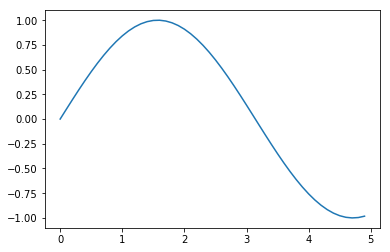

In [21]:
import matplotlib.pyplot as plt
x = np.arange(0, 5, 0.1)
y = np.sin(x)
plt.plot(x, y)
plt.show()